### This program attempts to optomize a users portfolio using the Efficient Frontier

In [79]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting
import marshal
from textwrap import shorten


plt.style.use("seaborn-v0_8-dark")
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [47]:
# Get the stocks tickers in the portfolio
# This is an notebook  example to optimse the portfolio
# Lets take as example FAANG
assets = ["META", "AMZN", "AAPL", "NFLX", "GOOG"]

In [48]:
# Assign weights to the stocks, which should addd up to 1
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

In [49]:
# Get the stocks/portfolio start date
start_date = "2013-01-01"

# Get the stocks/portfolio end date
today = datetime.today().strftime("%Y-%m-%d")

In [50]:
# Create a dataframe to store the adjusted close price of the stocks
df = pd.DataFrame()

# Store the adjsuted close price of the sotcks in the dataframe
for stock in assets:
    df[stock] = yf.download(stock, start=start_date, end=today)["Adj Close"]
df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,META,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,28.000000,12.865500,16.769093,13.144286,18.013729
2013-01-03,27.770000,12.924000,16.557432,13.798571,18.024191
2013-01-04,28.760000,12.957500,16.096226,13.711429,18.380356
2013-01-07,29.420000,13.423000,16.001549,14.171429,18.300158
2013-01-08,29.059999,13.319000,16.044605,13.880000,18.264042
...,...,...,...,...,...
2024-01-05,351.950012,145.240005,181.179993,474.059998,137.389999
2024-01-08,358.660004,149.100006,185.559998,485.029999,140.529999
2024-01-09,357.429993,151.369995,185.139999,482.089996,142.559998


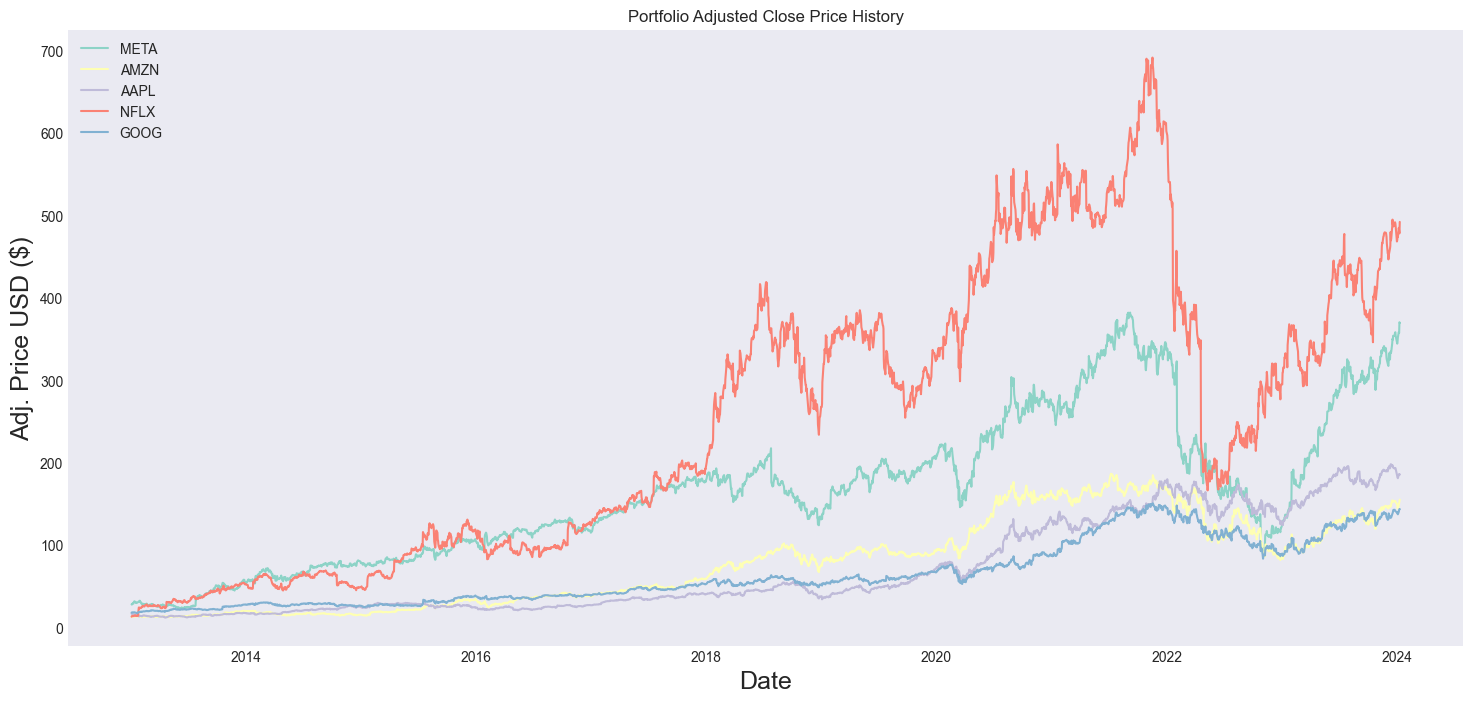

In [51]:
# Visualize the stock / portfolio
title = "Portfolio Adjusted Close Price History"

plt.figure(figsize=(18, 8))

for stock in df.columns.values:
    plt.plot(df[stock], label=stock)

plt.title(title)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj. Price USD ($)", fontsize=18)
plt.legend(df.columns.values, loc="upper left")
plt.show()

In [52]:
# Show daily simple return

returns = df.pct_change()
returns

,META,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.008214,0.004547,-0.012622,0.049777,0.000581
2013-01-04,0.035650,0.002592,-0.027855,-0.006315,0.019760
2013-01-07,0.022949,0.035925,-0.005882,0.033549,-0.004363
2013-01-08,-0.012237,-0.007748,0.002691,-0.020565,-0.001974
...,...,...,...,...,...
2024-01-05,0.013915,0.004634,-0.004013,-0.001285,-0.004709
2024-01-08,0.019065,0.026577,0.024175,0.023141,0.022855
2024-01-09,-0.003429,0.015225,-0.002263,-0.006061,0.014445


In [53]:
# Create and show the annualized covariance matrix
# Covariance matrix: Mathematical concept used in Statistics, which determines how much two random variables move together. It is the directional relationship between two assets prices.
# 252 -> nr of trading days in that year.

cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,META,AMZN,AAPL,NFLX,GOOG
META,0.146505,0.068308,0.052233,0.072520,0.062593
AMZN,0.068308,0.106497,0.046240,0.072002,0.056247
AAPL,0.052233,0.046240,0.080519,0.042741,0.043909
NFLX,0.072520,0.072002,0.042741,0.219782,0.054531
GOOG,0.062593,0.056247,0.043909,0.054531,0.075199


The diagonal line shows the variance of the different assets.
All the other entries are called the covariance.

If we take the square root of variance we get the volatility


In [54]:
# Calculate portfolio variance

portfolio_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
portfolio_variance

0.07084597380662169

In [55]:
# Calculate portfolio volatility aka std. deviation

portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_volatility

0.26616906996610573

In [56]:
# Calculate portfolio annual return

portfolio_simple_annual_return = np.sum(returns.mean() * weights) * 252
portfolio_simple_annual_return

0.3020355398667322

In [57]:
# show the expected annual return, volatility (risk), and variance

percent_var = str(round(portfolio_variance, 2) * 100) + "%"
percent_vol = str(round(portfolio_volatility, 2) * 100) + "%"
percent_return = str(round(portfolio_simple_annual_return, 2) * 100) + "%"

print(f"Expected annual return: {percent_return}")
print(f"Annual Volatility/risk: {percent_vol}")
print(f"Annual Variance: {percent_var}")

Expected annual return: 30.0%
Annual Volatility/risk: 27.0%
Annual Variance: 7.000000000000001%


### 

### Portfolio Optimization !
- I want to increase Expected annual return, and reducing my risk.

In [70]:
# Calculate the expected returns and the annualised sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimise for maximum sharpe ratio with objective function:
# Sharp ratio is a way to describe how much excess return you receive for some amount of volatility.
# Measures the performance of an investment compared to a risk-free investment (bonds or Treasury bills)
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)
weights = ef.max_sharpe()

# Helper methods to clean raw methods it sets. Whose absolute value are below some cutoff (defaulted on the method)
# It is going to get rid of the stocks we dont need to optimise the portfolio
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

ef.portfolio_performance(verbose=True)

OrderedDict([('META', 0.06268), ('AMZN', 0.1381), ('AAPL', 0.46089), ('NFLX', 0.29342), ('GOOG', 0.04491)])
Expected annual return: 28.8%
Annual volatility: 27.1%
Sharpe Ratio: 0.99


(0.28766599351127853, 0.2706269203266738, 0.9890590085723137)

Doesn't look better, it depends on the year

In [69]:
# Get discrete allocation of each share per stock

latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=15_000)

allocation, leftover = da.lp_portfolio()

print(f"Discrete allocation (shares): {allocation}")
print(f"Funds remaining: ${leftover:.2f}")

Discrete allocation (shares): {'AMZN': 15, 'AAPL': 38, 'NFLX': 9, 'GOOG': 7}
Funds remaining: $184.12


/Users/tdafonseca/Desktop/6-Github/learning/portfolio-optimization/.venv/lib/python3.9/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# For plotting purposes

/Users/tdafonseca/Desktop/6-Github/learning/portfolio-optimization/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


OrderedDict([('META', 0.06268), ('AMZN', 0.1381), ('AAPL', 0.46089), ('NFLX', 0.29342), ('GOOG', 0.04491)])
Expected annual return: 28.8%
Annual volatility: 27.1%
Sharpe Ratio: 0.99


(0.28766599351127853, 0.2706269203266738, 0.9890590085723137)

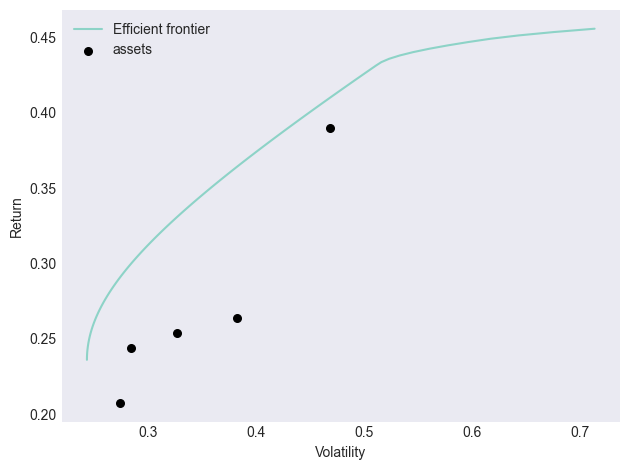

In [74]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Create the EfficientFrontier instance
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))

# Add constraints
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)

# Plot the efficient frontier BEFORE calling the optimization method
plotting.plot_efficient_frontier(ef)

# After plotting, create a new instance for optimization
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

/Users/tdafonseca/Desktop/6-Github/learning/portfolio-optimization/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


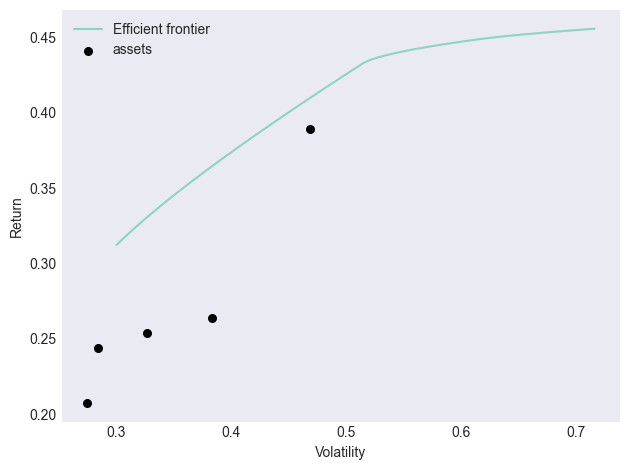

OrderedDict([('META', 0.06268), ('AMZN', 0.1381), ('AAPL', 0.46089), ('NFLX', 0.29342), ('GOOG', 0.04491)])
Expected annual return: 28.8%
Annual volatility: 27.1%
Sharpe Ratio: 0.99


(0.28766599351127853, 0.2706269203266738, 0.9890590085723137)

In [75]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)

# 1000 portfolios with risk range between 30% and 80%
risk_range = np.linspace(0.30, 0.80, 1000)
plotting.plot_efficient_frontier(
    ef, ef_param="risk", ef_param_range=risk_range, show_assets=True, showfig=True
)

# After plotting, create a new instance for optimization
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] + w[4] == 1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

### Analyse not only the optimal portfolio as a result Efficient Frontier optimizer

/Users/tdafonseca/Desktop/6-Github/learning/portfolio-optimization/.venv/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


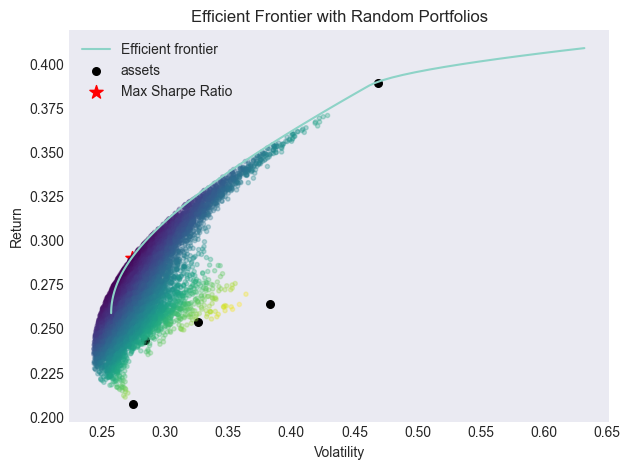

In [81]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximum Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] == 1)
weights = ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()

# Create a new instance for plotting the efficient frontier
ef_for_plotting = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef_for_plotting.add_constraint(lambda w: w[0] + w[1] + w[2] + w[3] == 1)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_for_plotting, ax=ax, show_assets=True)

# Mark the point for max Sharpe ratio on the plot
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe Ratio")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu.T)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r", alpha=0.3)

# Output
ax.set_title("Efficient Frontier with Random Portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("./figures/ef_scatter_notebook.png")
plt.show()

<Axes: >

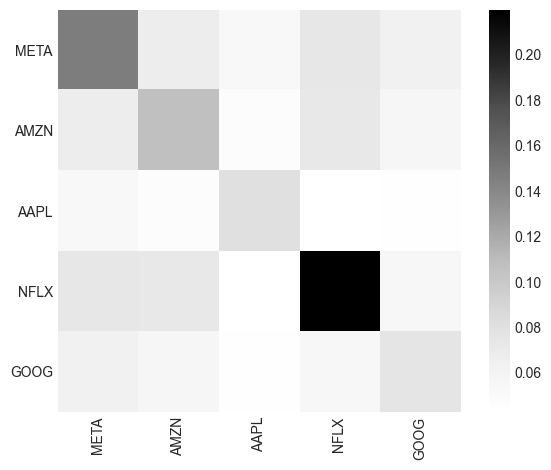

In [87]:
plotting.plot_covariance(S, plot_correlation=False, show_tickers=True)